# `Ismail Qayyum  k213118`

# Original dataset

Files already downloaded and verified
torch.Size([64, 3, 128, 128])


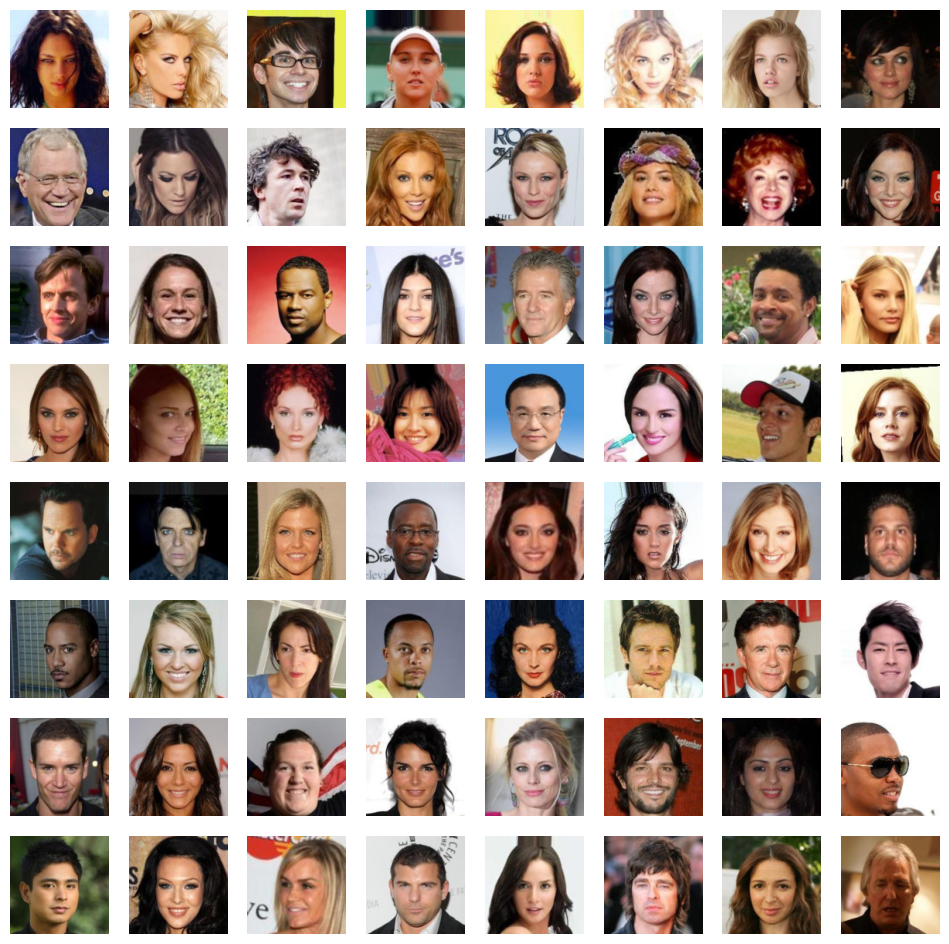

In [4]:
import torchvision
from matplotlib import pyplot as plt
import torch
import torchvision.transforms as transforms

# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CelebA dataset
trainset = torchvision.datasets.CelebA(root='./data', split='train', download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Plot some sample images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Denormalize the images for plotting
images = images * 0.5 + 0.5

# Plot the images
print(images.shape)
fig, axes = plt.subplots(figsize=(12, 12), nrows=8, ncols=8, sharex=True, sharey=True)
for ax, img in zip(axes.flatten(), images):
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')
plt.show()

(<matplotlib.image.AxesImage at 0x19980c1f220>, (-0.5, 127.5, 127.5, -0.5))

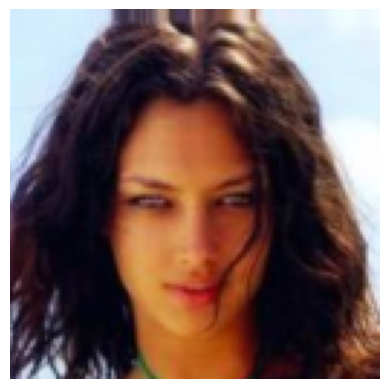

In [5]:
plt.imshow(images[0].permute(1, 2, 0)),plt.axis('off')

In [6]:
len(trainset), len(train_loader), images.shape, labels.shape

(162770, 2544, torch.Size([64, 3, 128, 128]), torch.Size([64, 40]))

# First Model (Experimenting with low resolution)

In [6]:


import pynvml
import psutil

def get_gpu_info():
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)  # Assuming a single GPU
    gpu_utilization = pynvml.nvmlDeviceGetUtilizationRates(handle).gpu
    gpu_temperature = pynvml.nvmlDeviceGetTemperature(handle, pynvml.NVML_TEMPERATURE_GPU)
    pynvml.nvmlShutdown()
    return gpu_utilization, gpu_temperature

def get_cpu_info():
    cpu_utilization = psutil.cpu_percent(interval=1)
    try:
        # On Linux, you can get CPU temperature using psutil.sensors_temperatures()
        cpu_temperature = psutil.sensors_temperatures()['coretemp'][0].current
    except (AttributeError, KeyError):
        cpu_temperature = "N/A"  # CPU temperature monitoring is not available on this system
    return cpu_utilization, cpu_temperature

gpu_utilization, gpu_temperature = get_gpu_info()
cpu_utilization, cpu_temperature = get_cpu_info()

print(f"GPU Utilization: {gpu_utilization}%")
print(f"GPU Temperature: {gpu_temperature}°C")
print(f"CPU Utilization: {cpu_utilization}%")
print(f"CPU Temperature: {cpu_temperature}°C")

GPU Utilization: 0%
GPU Temperature: 37°C
CPU Utilization: 26.0%
CPU Temperature: N/A°C


Epoch [100/100], Step [5087/5087], d_loss: 0.3567, g_loss: 3.3505, D(x): 0.92, D(G(z)): 0.01
GPU Utilization: 38%
GPU Temperature: 47°C
CPU Utilization: 10.1%
CPU Temperature: N/A°C


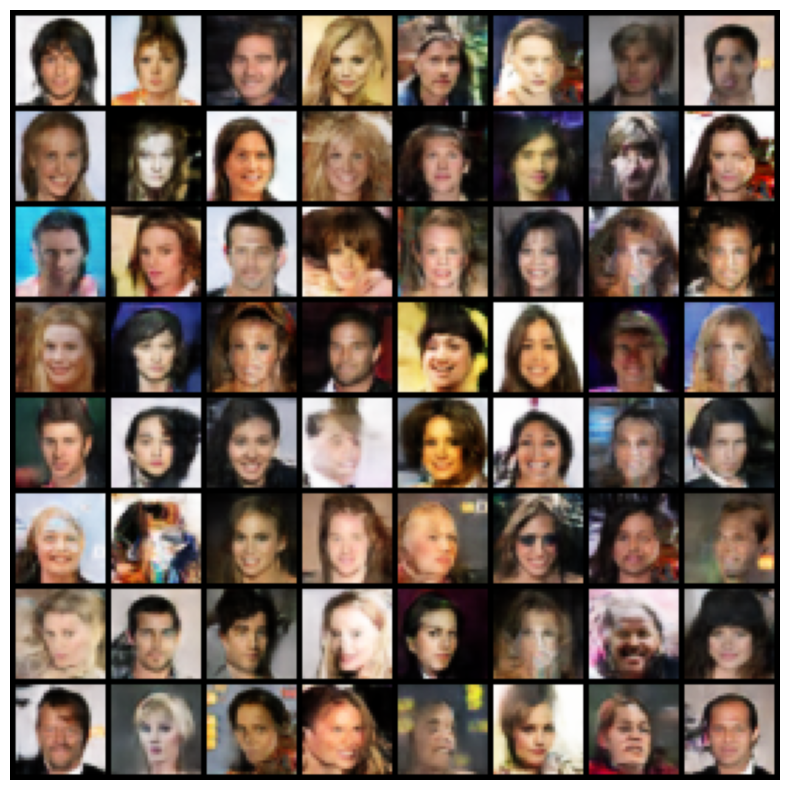

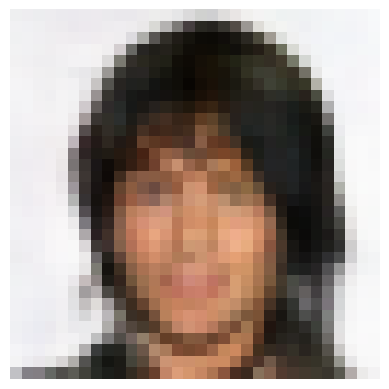

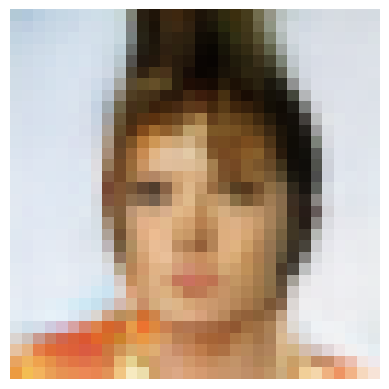

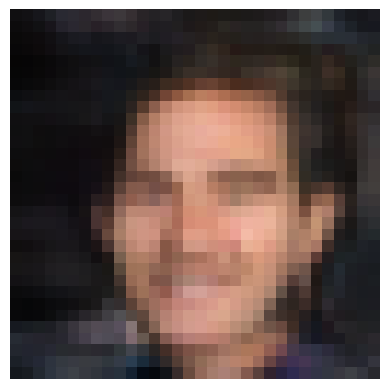

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt

# Simplified Generator
class Generator_CelebA(nn.Module):
    def __init__(self):
        super().__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(100, 256, kernel_size=4, stride=1, padding=0),  # 4x4x256
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8x128
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16x64
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # 32x32x3
            nn.Tanh()
        )

    def forward(self, x):
        return self.generator(x)

# Simplified Discriminator
class Discriminator_CelebA(nn.Module):
    def __init__(self):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 16x16x64
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 8x8x128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 4x4x256
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),  # 1x1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device}')

generator_model = Generator_CelebA().to(device)
discriminator_model = Discriminator_CelebA().to(device)

# Set the models to training mode
generator_model.train()
discriminator_model.train()

# Define the loss function and optimizers
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator_model.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Data loading
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CelebA(root='./data', download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

epochs = 100
for epoch in range(epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        real_labels = torch.ones(images.size(0), 1).to(device) * 0.9  # Label smoothing to avoid the discriminator from being overconfident 
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        # Training the discriminator on real images
        outputs = discriminator_model(images)
        d_loss_real = criterion(outputs.squeeze(), real_labels.squeeze())
        real_score = outputs

        # Training the discriminator on fake images
        noise = torch.randn(images.size(0), 100, 1, 1).to(device)
        fake_images = generator_model(noise)
        outputs = discriminator_model(fake_images.detach())
        d_loss_fake = criterion(outputs.squeeze(), fake_labels.squeeze())
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake
        discriminator_model.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Training the generator
        noise = torch.randn(images.size(0), 100, 1, 1).to(device)
        fake_images = generator_model(noise)
        outputs = discriminator_model(fake_images)
        g_loss = criterion(outputs.squeeze(), real_labels.squeeze())

        generator_model.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    clear_output(wait=True)

    print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    gpu_utilization, gpu_temperature = get_gpu_info()
    cpu_utilization, cpu_temperature = get_cpu_info()

    print(f"GPU Utilization: {gpu_utilization}%")
    print(f"GPU Temperature: {gpu_temperature}°C")
    print(f"CPU Utilization: {cpu_utilization}%")
    print(f"CPU Temperature: {cpu_temperature}°C")

    # Plotting the generated images
    with torch.no_grad():
        noise = torch.randn(64, 100, 1, 1).to(device)
        fake_images = generator_model(noise).detach().cpu()
        fake_images = (fake_images + 1) / 2  # Rescale to [0, 1]
        grid = torchvision.utils.make_grid(fake_images, nrow=8, padding=2, normalize=True)
        npimg = grid.numpy()
        plt.figure(figsize=(10, 10))
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
        plt.show()

        for i in range(3):
            plt.imshow(fake_images[i].permute(1, 2, 0).detach().cpu().numpy())
            plt.axis('off')
            plt.show()

    # Save the model checkpoints
    torch.save(generator_model.state_dict(), 'SavedModels/celebA_generator.pth')
    torch.save(discriminator_model.state_dict(), 'SavedModels/celebA_discriminator.pth')


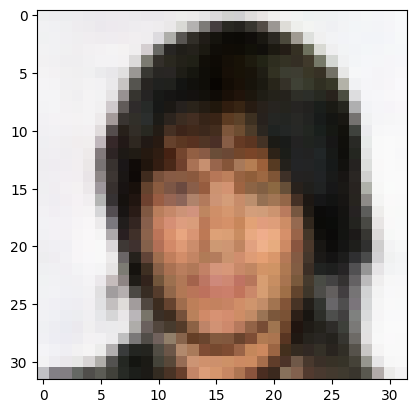

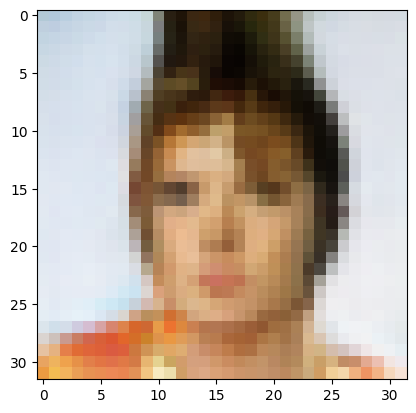

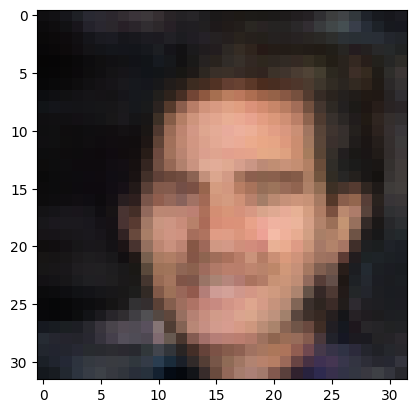

In [44]:
for i in range(3):
            plt.imshow(fake_images[i].permute(1, 2, 0).detach().cpu().numpy(), interpolation='nearest')
           # plt.axis('off')
            plt.show()


# Improved model with better resolution 

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt

class Generator_CelebA(nn.Module):
    def __init__(self):
        super(Generator_CelebA, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, padding=0),  # 4x4x512
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 8x8x256
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 16x16x128
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 32x32x64
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64x64x32
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 128x128x3
            nn.Tanh()
        )

    def forward(self, x):
        return self.generator(x)

# Simplified Discriminator
class Discriminator_CelebA(nn.Module):
    def __init__(self):
        super(Discriminator_CelebA, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 64x64x32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32x32x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16x128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8x256
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 4x4x512
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),  # 1x1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)

Epoch [50/50], Step [5087/5087], d_loss: 0.4223, g_loss: 5.1180, D(x): 0.97, D(G(z)): 0.03
GPU Utilization: 60%
GPU Temperature: 66°C
CPU Utilization: 10.8%
CPU Temperature: N/A°C


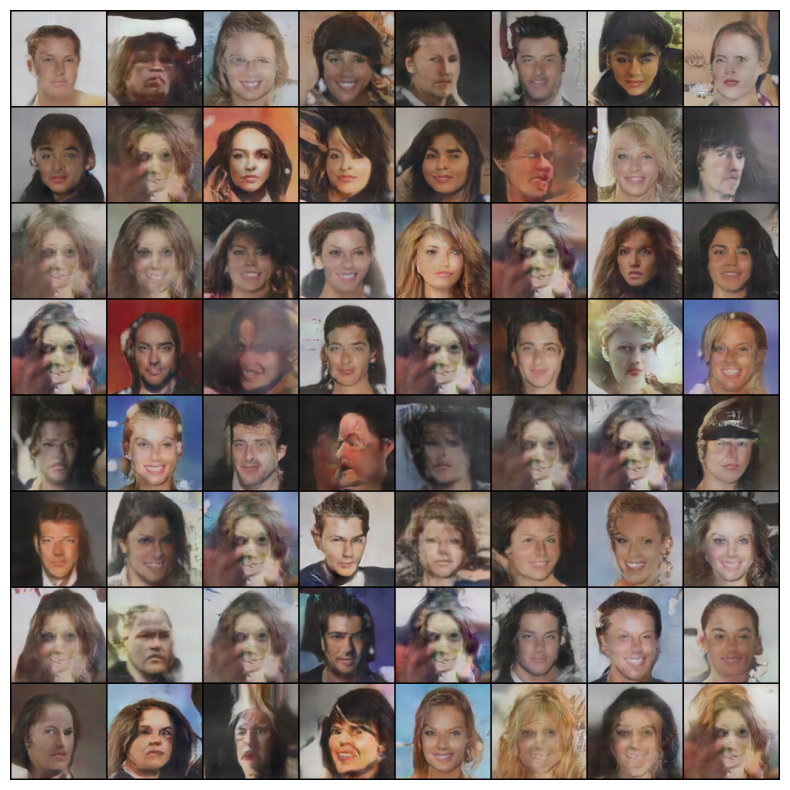

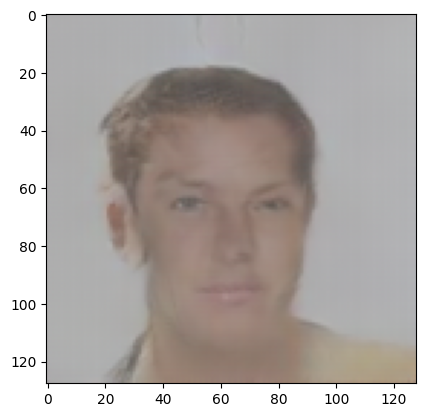

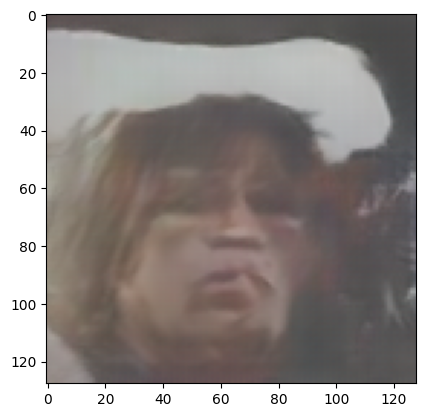

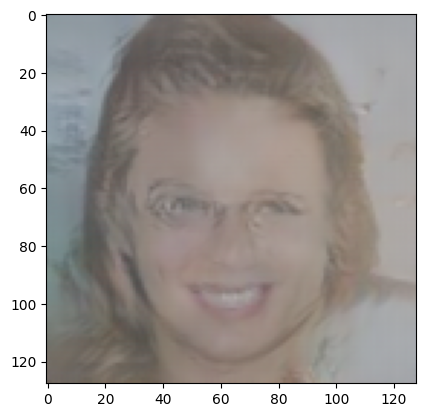

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt

# Simplified Generator
# Simplified Generator
class Generator_CelebA(nn.Module):
    def __init__(self):
        super(Generator_CelebA, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, padding=0),  # 4x4x512
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 8x8x256
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 16x16x128
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 32x32x64
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64x64x32
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 128x128x3
            nn.Tanh()
        )

    def forward(self, x):
        return self.generator(x)

# Simplified Discriminator
class Discriminator_CelebA(nn.Module):
    def __init__(self):
        super(Discriminator_CelebA, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 64x64x32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32x32x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16x128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8x256
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 4x4x512
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),  # 1x1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)

    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device}')

generator_model = Generator_CelebA().to(device)
discriminator_model = Discriminator_CelebA().to(device)

# Set the models to training mode
generator_model.train()
discriminator_model.train()

# Define the loss function and optimizers
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator_model.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Data loading
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CelebA(root='./data', download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

epochs = 50

for epoch in range(epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        real_labels = torch.ones(images.size(0), 1).to(device) * 0.9  # Label smoothing to avoid the discriminator from being overconfident 
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        # Training the discriminator on real images
        outputs = discriminator_model(images)
        d_loss_real = criterion(outputs.squeeze(), real_labels.squeeze())
        real_score = outputs

        # Training the discriminator on fake images
        noise = torch.randn(images.size(0), 100, 1, 1).to(device)
        fake_images = generator_model(noise)
        outputs = discriminator_model(fake_images.detach())
        d_loss_fake = criterion(outputs.squeeze(), fake_labels.squeeze())
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake
        discriminator_model.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Training the generator
        noise = torch.randn(images.size(0), 100, 1, 1).to(device)
        fake_images = generator_model(noise)
        outputs = discriminator_model(fake_images)
        g_loss = criterion(outputs.squeeze(), real_labels.squeeze())

        generator_model.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    clear_output(wait=True)

    print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    gpu_utilization, gpu_temperature = get_gpu_info()
    cpu_utilization, cpu_temperature = get_cpu_info()

    print(f"GPU Utilization: {gpu_utilization}%")
    print(f"GPU Temperature: {gpu_temperature}°C")
    print(f"CPU Utilization: {cpu_utilization}%")
    print(f"CPU Temperature: {cpu_temperature}°C")

    # Plotting the generated images
    with torch.no_grad():
        noise = torch.randn(64, 100, 1, 1).to(device)
        fake_images = generator_model(noise).detach().cpu()
        fake_images = (fake_images + 1) / 2

        grid = torchvision.utils.make_grid(fake_images, nrow=8, padding=2, normalize=True)
        npimg = grid.numpy()
        plt.figure(figsize=(10, 10))
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
        plt.show()

        for i in range(3):
            plt.imshow(fake_images[i].permute(1, 2, 0).detach().cpu().numpy())
            #plt.axis('off')
            plt.show()

    # Save the model checkpoints
    torch.save(generator_model.state_dict(), 'SavedModels/celebA_deep_generator.pth')
    torch.save(discriminator_model.state_dict(), 'SavedModels/celebA_deep_discriminator.pth')

Loading my model and fetching results


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator_model = Generator_CelebA().to(device)
discriminator_model = Discriminator_CelebA().to(device)

generator_model.load_state_dict(torch.load('SavedModels\celebA_deep_generator.pth'))
discriminator_model.load_state_dict(torch.load('SavedModels/celebA_deep_discriminator.pth'))

<All keys matched successfully>

# Model Generated Images after training


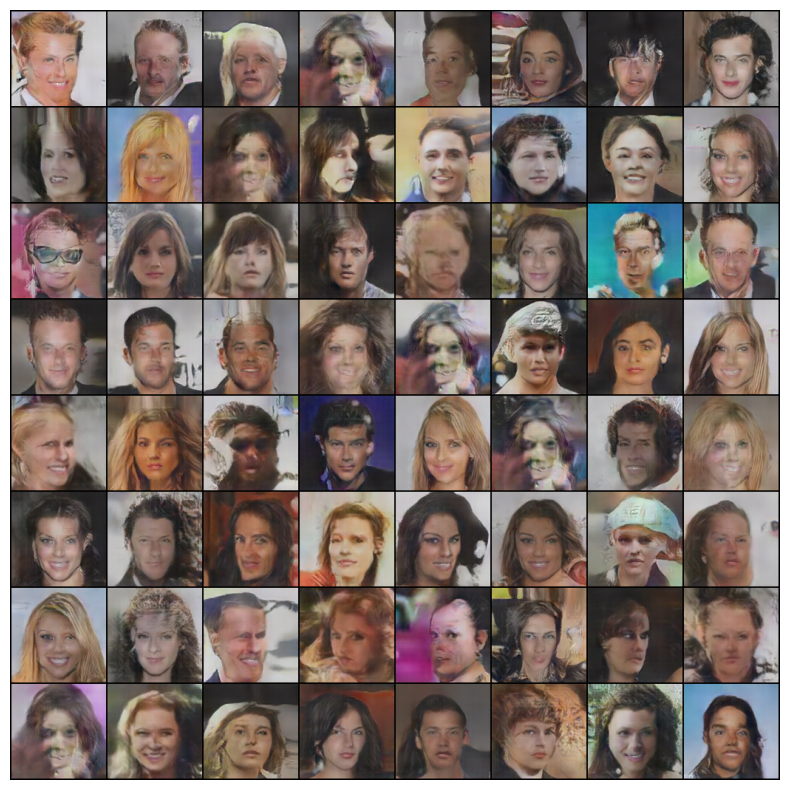

In [31]:


# Plotting the generated images
with torch.no_grad():
    noise = torch.randn(64, 100, 1, 1).to(device)
    fake_images = generator_model(noise).detach().cpu()
    fake_images = (fake_images + 1) / 2

    grid = torchvision.utils.make_grid(fake_images, nrow=8, padding=2, normalize=True)
    npimg = grid.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Final results of my model after training from scratch

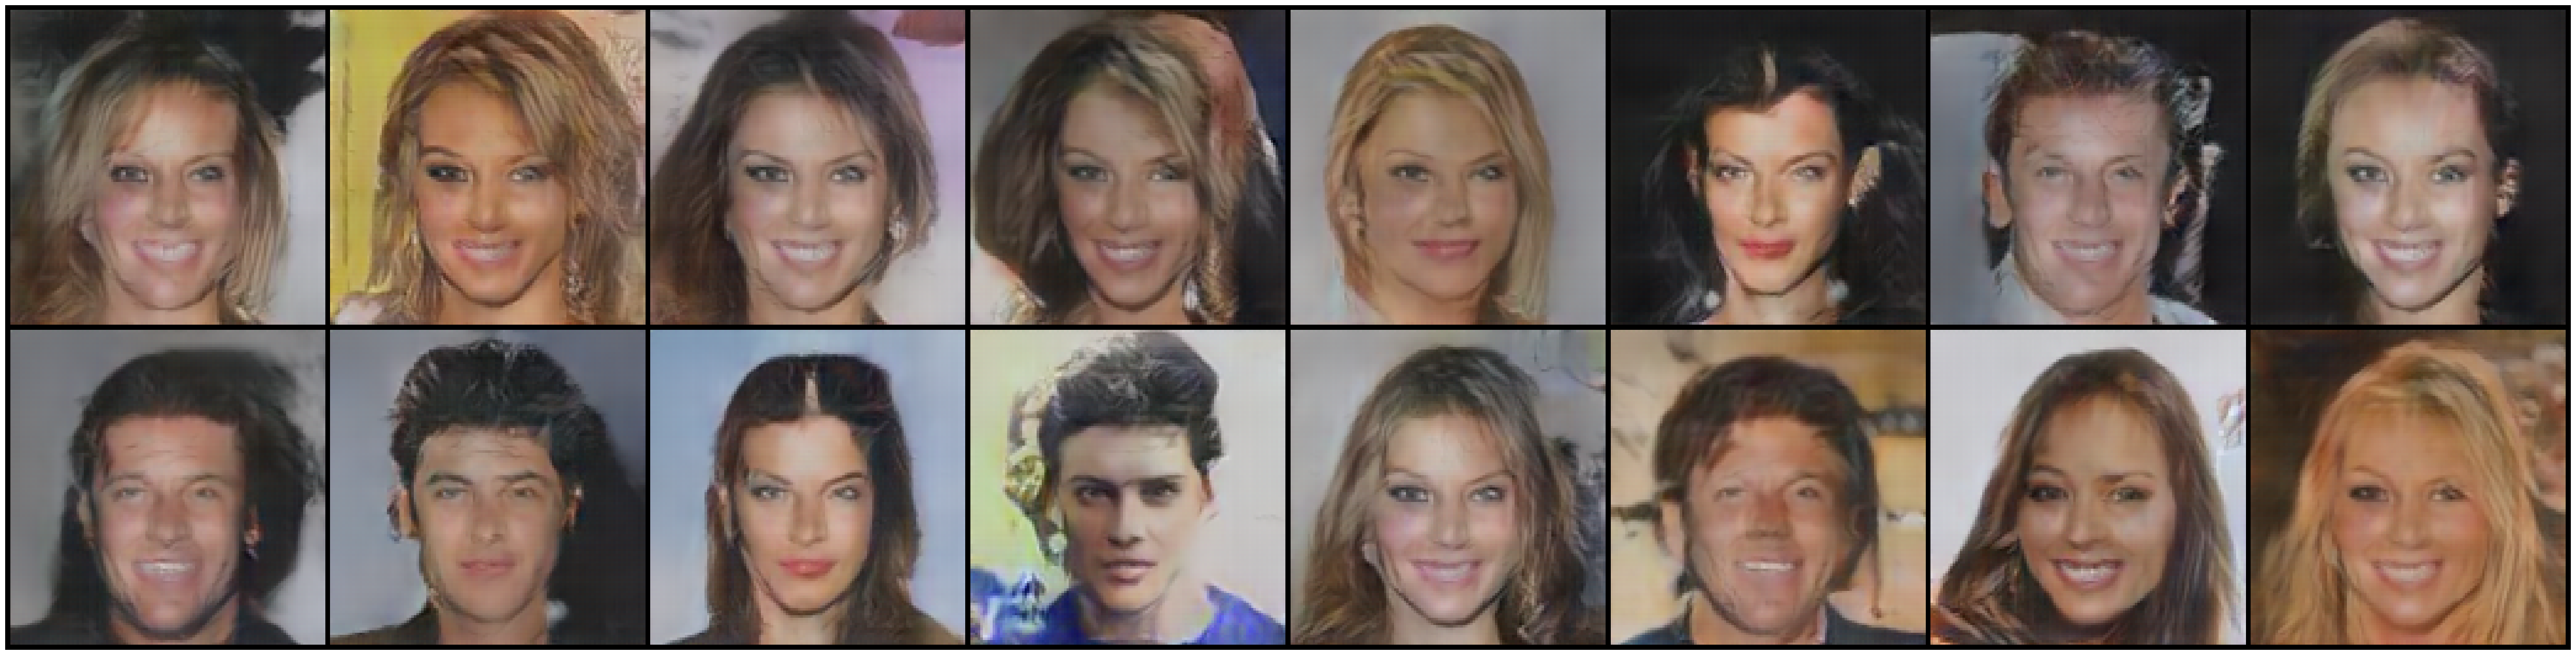

In [359]:
import torchvision

grid = torchvision.utils.make_grid([torch.tensor(img).permute(2, 0, 1) for img in cherry], nrow=8, padding=2, normalize=True)

np_grid = grid.numpy()

plt.figure(figsize=(64, 64))
plt.imshow(np.transpose(np_grid, (1, 2, 0)))
plt.axis('off')
plt.show()


In [1]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [2]:
x = torch.arange(-5, 5, 0.1).view(-1, 1)
y = -5 * x + 0.1 * torch.randn(x.size())

model = torch.nn.Linear(1, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

def train_model(iter):
    for epoch in range(iter):
        y1 = model(x)
        loss = criterion(y1, y)
        writer.add_scalar("Loss/meow", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

train_model(10)
writer.flush()

In [ ]:
pip install protobuf==3.20.*

Epoch [7/50], Step [2544/2544], d_loss: 1.1526, g_loss: 0.3424, D(x): 0.40, D(G(z)): 0.00
running on cuda
GPU Utilization: 2%
GPU Temperature: 69°C
CPU Utilization: 6.2%
CPU Temperature: N/A°C


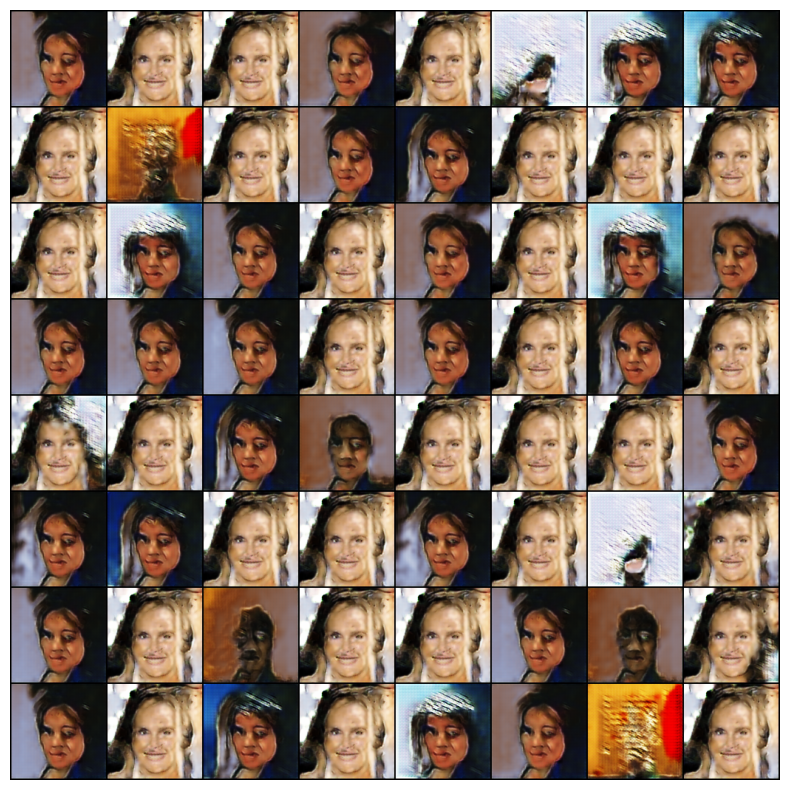

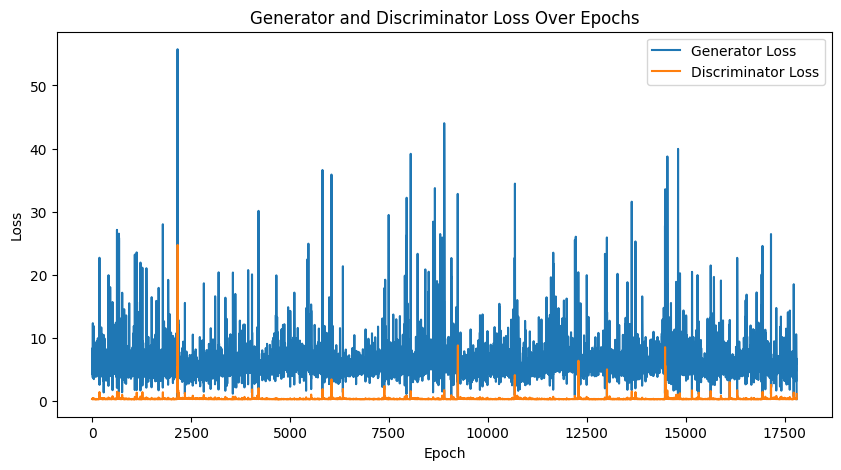

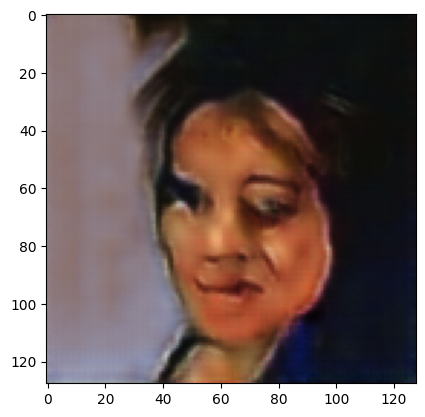

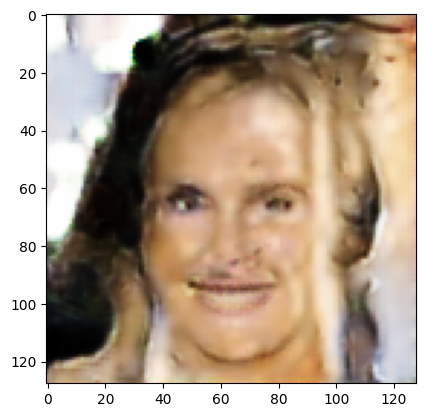

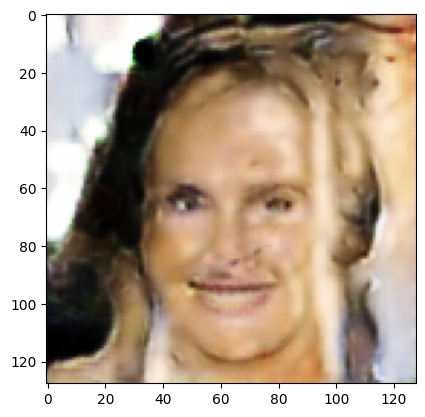

KeyboardInterrupt: 

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt
import pynvml



import pynvml
import psutil

def get_gpu_info():
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)  # Assuming a single GPU
    gpu_utilization = pynvml.nvmlDeviceGetUtilizationRates(handle).gpu
    gpu_temperature = pynvml.nvmlDeviceGetTemperature(handle, pynvml.NVML_TEMPERATURE_GPU)
    pynvml.nvmlShutdown()
    return gpu_utilization, gpu_temperature

def get_cpu_info():
    cpu_utilization = psutil.cpu_percent(interval=1)
    try:
        # On Linux, you can get CPU temperature using psutil.sensors_temperatures()
        cpu_temperature = psutil.sensors_temperatures()['coretemp'][0].current
    except (AttributeError, KeyError):
        cpu_temperature = "N/A"  # CPU temperature monitoring is not available on this system
    return cpu_utilization, cpu_temperature

gpu_utilization, gpu_temperature = get_gpu_info()
cpu_utilization, cpu_temperature = get_cpu_info()

print(f"GPU Utilization: {gpu_utilization}%")
print(f"GPU Temperature: {gpu_temperature}°C")
print(f"CPU Utilization: {cpu_utilization}%")
print(f"CPU Temperature: {cpu_temperature}°C")

# Simplified Generator
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels)
        )
        
    def forward(self, x):
        return x + self.block(x)  # Skip connection

class DeepenedGenerator_CelebA(nn.Module):
    def __init__(self):
        super(DeepenedGenerator_CelebA, self).__init__()
        self.initial = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, padding=0),  # 4x4x512
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )

        # Adding depth with residual blocks
        self.main = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 8x8x256
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            #ResidualBlock(256),

            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),  # Additional conv layer
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            #ResidualBlock(256),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 16x16x128
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            ResidualBlock(128),

            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),  # Additional conv layer
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            #ResidualBlock(128),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 32x32x64
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            #ResidualBlock(64),

            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1),  # Additional conv layer
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            #ResidualBlock(64),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64x64x32
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            ResidualBlock(32),

            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1),  # Additional conv layer
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            #ResidualBlock(32),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 128x128x3
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.main(x)
        return x

class DeepenedDiscriminator_CelebA(nn.Module):
    def __init__(self):
        super(DeepenedDiscriminator_CelebA, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 64x64x32
    
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32x32x64

            nn.LeakyReLU(0.2, inplace=True),

   

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16x128
       
            nn.LeakyReLU(0.2, inplace=True),

            ResidualBlock(128),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8x256
       
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 4x4x512
           
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),  # 1x1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device}')

generator_model = DeepenedGenerator_CelebA().to(device)
discriminator_model = DeepenedDiscriminator_CelebA().to(device)

generator_model.load_state_dict(torch.load('ResModels\gen2_resModel.pth'))

discriminator_model.load_state_dict(torch.load('ResModels\disc2_resModel.pth'))

# Set the models to training mode
generator_model.train()
discriminator_model.train()

# Define the loss function and optimizers
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator_model.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Data loading
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CelebA(root='./data', download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True,num_workers=4)
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
epochs = 50
g_losses=[]
d_losses=[]
for epoch in range(epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        real_labels = torch.ones(images.size(0), 1).to(device) * 0.9  # Label smoothing to avoid the discriminator from being overconfident 
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        # Training the discriminator on real images
        outputs = discriminator_model(images)
        d_loss_real = criterion(outputs.squeeze(), real_labels.squeeze())
        real_score = outputs

        # Training the discriminator on fake images
        noise = torch.randn(images.size(0), 100, 1, 1).to(device)
        fake_images = generator_model(noise)
        outputs = discriminator_model(fake_images.detach())
        d_loss_fake = criterion(outputs.squeeze(), fake_labels.squeeze())
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake
        d_losses.append(d_loss.item())
        discriminator_model.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Training the generator
        noise = torch.randn(images.size(0), 100, 1, 1).to(device)
        fake_images = generator_model(noise)
        outputs = discriminator_model(fake_images)
        g_loss = criterion(outputs.squeeze(), real_labels.squeeze())
        g_losses.append(g_loss.item())

        generator_model.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    clear_output(wait=True)

    print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    gpu_utilization, gpu_temperature = get_gpu_info()
    cpu_utilization, cpu_temperature = get_cpu_info()

    print(f'running on {device}')

    print(f"GPU Utilization: {gpu_utilization}%")
    print(f"GPU Temperature: {gpu_temperature}°C")
    print(f"CPU Utilization: {cpu_utilization}%")
    print(f"CPU Temperature: {cpu_temperature}°C")

    # Plotting the generated images
    with torch.no_grad():
        noise = torch.randn(64, 100, 1, 1).to(device)
        fake_images = generator_model(noise).detach().cpu()
        fake_images = (fake_images + 1) / 2

        grid = torchvision.utils.make_grid(fake_images, nrow=8, padding=2, normalize=True)
        npimg = grid.numpy()
        plt.figure(figsize=(10, 10))
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
        plt.show()

        # Plotting the loss graphs
        plt.figure(figsize=(10, 5))
        plt.plot(g_losses, label='Generator Loss')
        plt.plot(d_losses, label='Discriminator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Generator and Discriminator Loss Over Epochs')
        plt.show()


        for i in range(3):
            plt.imshow(fake_images[i].permute(1, 2, 0).detach().cpu().numpy())
            #plt.axis('off')
            plt.show()

        # writer.add_scalar("Batch-Gen-Loss", g_losses.item(), epoch+1)
        # writer.add_scalar("Batch-Dis-Loss", d_losses.item(), epoch+1)

    writer.add_scalar("Avg-Gen-Loss", sum(g_losses)/len(g_losses), epoch+1)
    writer.add_scalar("Avg-Disc-Loss", sum(d_losses)/len(d_losses), epoch+1)
    writer.add_image("Generated Images", grid, epoch+1)



    # Save the model checkpoints
    torch.save(generator_model.state_dict(), 'ResModels/gen2_resModel.pth')
    torch.save(discriminator_model.state_dict(), 'ResModels/disc2_resModel.pth')